# Credit Default Prediction
## Vathana Thy & Toby Johnstone

#### Import libraries

In [ ]:

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
import datetime as dt


# Data Cleaning

Read data from file into pandas dataframe

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CreditTraining.csv to CreditTraining.csv


In [ ]:
import io
df = pd.read_csv('CreditTraining.csv')

A first look at the data shows we have information regarding 5380 customers and a variety of information about each customer.

In [ ]:
df.shape

(5380, 19)

In [ ]:
df.head()

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,07/08/1977,13/02/2012,NP_Client,University,Married,3.0,1,36,1.0,C,14/02/2012,Sales,Owned,1,NaN,B
1,573,0,Existing Client,13/06/1974,04/02/2009,P_Client,University,Married,0.0,12,18,2.0,C,30/06/2011,Sales,Parents,1,NaN,G
2,9194,0,Non Existing Client,07/11/1973,03/04/2012,NP_Client,University,Married,2.0,10,36,1.0,C,04/04/2012,Sales,Owned,1,NaN,B
3,3016,1,Existing Client,08/07/1982,25/08/2011,NP_Client,University,Married,3.0,3,36,1.0,C,07/09/2011,Sales,New rent,1,31/12/2012,L
4,6524,0,Non Existing Client,18/08/1953,10/01/2012,NP_Client,University,Married,2.0,1,36,1.0,C,11/01/2012,Sales,Owned,1,NaN,D


First we convert the Net Annual Income to float values:

In [ ]:
df['Net_Annual_Income'] = df['Net_Annual_Income'].str.replace(',','.').astype(np.float64)

We then decided to extract relative time values from some of the date categories. Indeed, we believe that it is not the year of birth of a customer that is important but rather their age when taking out a loan. This means our model can be useful for predicting future outcomes as it is stationary. 
Hence, we replace the birthdate with the age of the client on the decision date and the customer open date with the time since opening.

In [ ]:
#Assumption on the current date is the latest date from dataframe
today = dt.datetime(2014,1,1)
df['months_closed'] = df['Prod_Closed_Date'].apply(lambda x: (today - pd.to_datetime(x)).days /30).fillna(0).astype('float64')

In [ ]:
df['Age'] = (pd.to_datetime(df['Prod_Decision_Date']) - pd.to_datetime(df['BirthDate']))/np.timedelta64(1, 'Y')
df['Time_since_opening'] = (pd.to_datetime(df['Prod_Decision_Date']) - pd.to_datetime(df['Customer_Open_Date']))/np.timedelta64(1, 'Y')

We drop the columns we no longer need. This includes the BirthDate, Customer_Open_Date and Prod_Decision_Date because we have already extracted the information from them into Age and Time_since_opening. Id_Customer is only of use for managing the data and will be no help predicting the outcome. Prod_Closed_Date has a large number of NaNs and since we have already extracted the useful information from it, so we decide to disregard this column.

In [ ]:
df = df.drop(columns=['Id_Customer', 'BirthDate', 'Customer_Open_Date', 'Prod_Decision_Date', 'Prod_Closed_Date'])

We now check if to see if the rest of the data contains any NaN values

In [ ]:
df.isnull().any()

Y                      False
Customer_Type          False
P_Client               False
Educational_Level      False
Marital_Status         False
Number_Of_Dependant     True
Years_At_Residence     False
Net_Annual_Income       True
Years_At_Business       True
Prod_Sub_Category      False
Source                 False
Type_Of_Residence      False
Nb_Of_Products         False
Prod_Category          False
months_closed          False
Age                    False
Time_since_opening     False
dtype: bool

It seems there are NaNs in a certain number of columns. We take a closer look at the lines which are affected.

In [ ]:
df[df.Number_Of_Dependant.isnull()]

,Y,Customer_Type,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Source,Type_Of_Residence,Nb_Of_Products,Prod_Category,months_closed,Age,Time_since_opening
634,1,Existing Client,P_Client,University,Single,NaN,21,33.6,1.0,C,Branch,Owned,2,G,9.2,21.785526,1.577034
5045,0,Existing Client,NP_Client,Master/PhD,Married,NaN,10,50.0,10.0,C,Sales,Owned,1,B,0.0,61.972525,7.603168


In [ ]:
df[df.Years_At_Business.isnull()]

,Y,Customer_Type,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Source,Type_Of_Residence,Nb_Of_Products,Prod_Category,months_closed,Age,Time_since_opening
1987,0,Non Existing Client,NP_Client,Master/PhD,Single,0.0,10,25.0,NaN,C,Branch,Owned,2,D,14.733333,27.031356,0.019165
2750,0,Non Existing Client,NP_Client,University,Married,0.0,2,108.0,NaN,C,Branch,Owned,1,B,0.000000,30.385292,0.035593


In [ ]:
df[df.Net_Annual_Income .isnull()]

,Y,Customer_Type,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Source,Type_Of_Residence,Nb_Of_Products,Prod_Category,months_closed,Age,Time_since_opening
1879,0,Non Existing Client,NP_Client,University,Married,0.0,10,NaN,10.0,C,Sales,Owned,1,B,12.466667,44.006379,0.002738
5144,0,Non Existing Client,NP_Client,University,Married,0.0,11,NaN,0.0,C,Branch,Old rent,2,B,11.533333,61.279835,0.008214


Since few lines are affected (only 2 in each case), and it is not clear in each case what the NaN means (perhaps a lack of information) we decide to simply drop these lines

In [ ]:
df = df.drop(df.loc[df.Number_Of_Dependant.isnull()].index)
df = df.drop(df.loc[df.Years_At_Business.isnull()].index)
df = df.drop(df.loc[df.Net_Annual_Income.isnull()].index)
df.isnull().sum()

Y                      0
Customer_Type          0
P_Client               0
Educational_Level      0
Marital_Status         0
Number_Of_Dependant    0
Years_At_Residence     0
Net_Annual_Income      0
Years_At_Business      0
Prod_Sub_Category      0
Source                 0
Type_Of_Residence      0
Nb_Of_Products         0
Prod_Category          0
months_closed          0
Age                    0
Time_since_opening     0
dtype: int64

Below we take a look at the number of '0's for the value of Y and compare it to the number of '1's

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


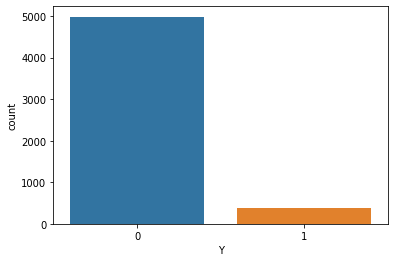

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df['Y'],label="Sum")

plt.show()

We then plot the correlation matrix of our features

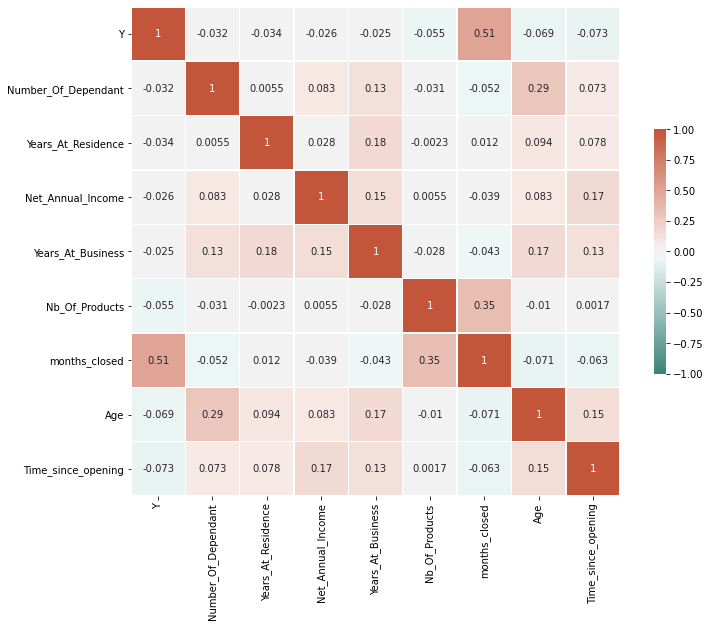

In [ ]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, square=True)
cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(corrmat, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

We then transform some of the categorical variables. In particular, the level of education has a clear ranking and should be ordinal. We also convert binary categories to 0s and 1s.

In [ ]:

data = df.replace({"P_Client" : {"NP_Client" : 0, "P_Client" : 1}, 
                "Educational_Level" : {"Secondary or Less" : 0, "Diploma":1 , "University" : 2, "Master/PhD" : 3},
                "Customer_Type": {"Existing Client": 1, "Non Existing Client": 0},
                "Source": {"Branch": 0, "Sales" :1}})

The rest of the categorical variables are converted to dummies

In [ ]:
#Convert to dummies
df = pd.get_dummies(data)
clean_data = df

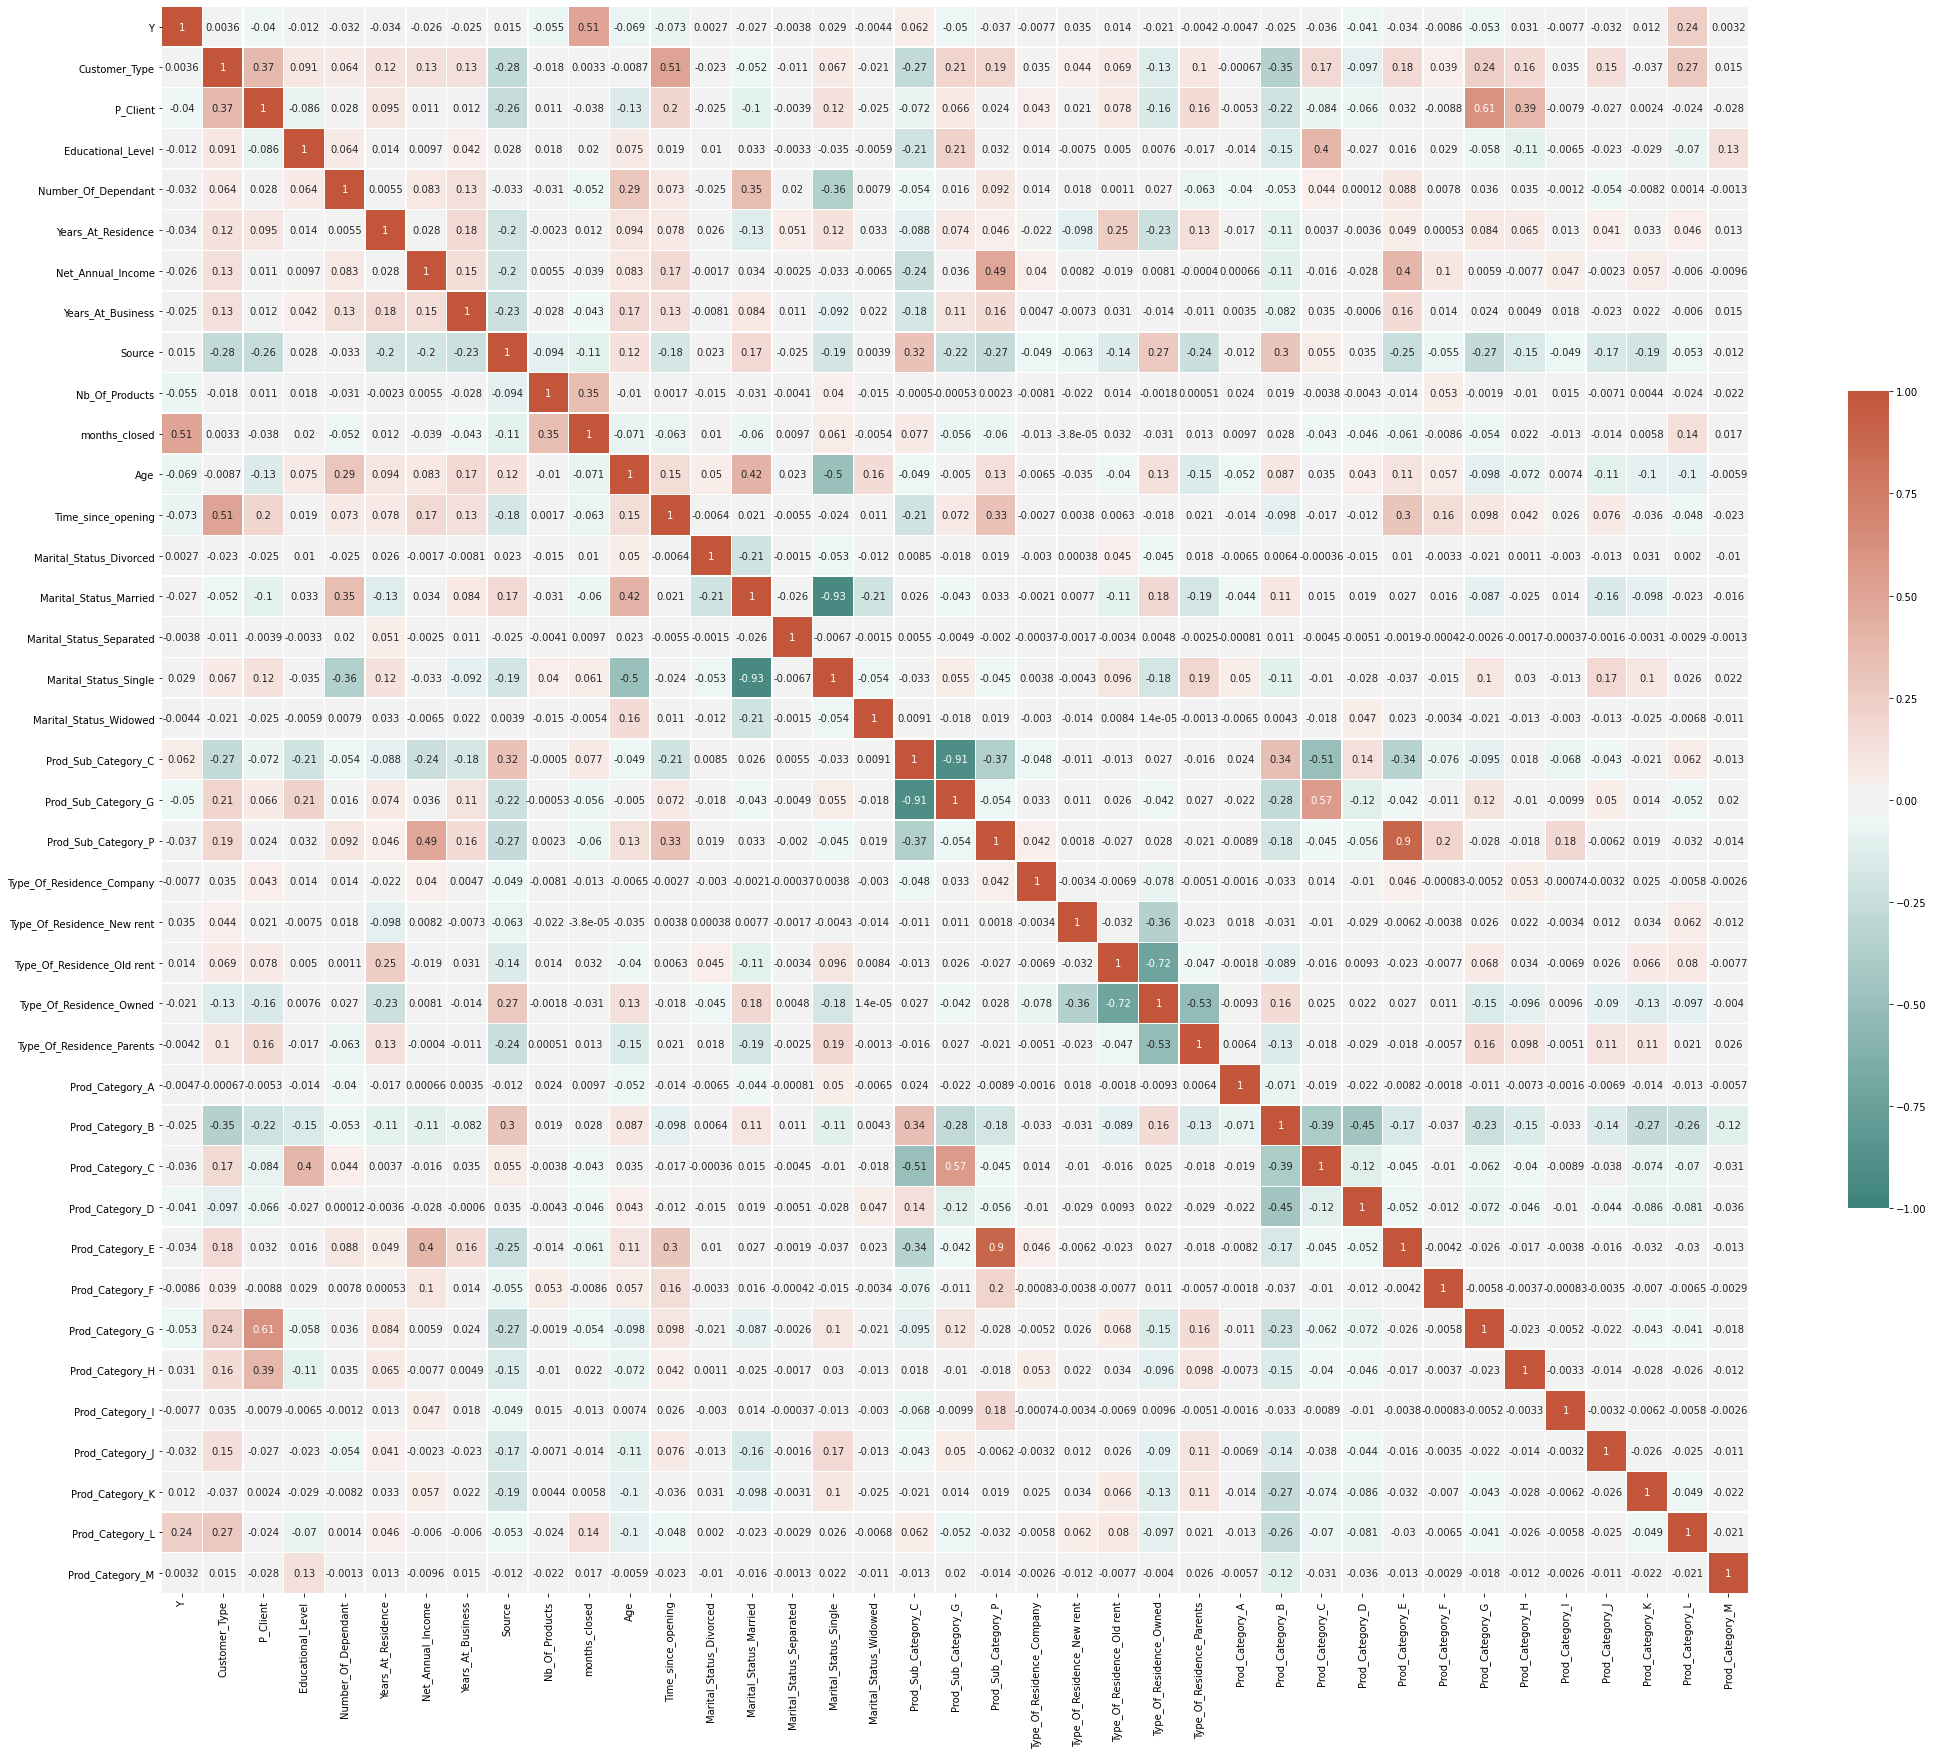

In [ ]:
#correlation matrix again
corrmat = df.corr()
f, ax = plt.subplots(figsize=(30, 25))
cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(corrmat, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()
plt.show()


We split the data for training and validation. The variable we are trying to predict `y` is seperated, and 1/3 of the data is put to the side for validation.

In [ ]:
df_train = df.drop(columns='Y')
y = df.Y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train,y,test_size=0.34)
print(X_train.shape)
print(X_test.shape)
print(np.sum( y_train))
print(np.sum( y_test))

(3546, 38)
(1828, 38)
253
139


## Parameters tuning and Models for prediction
Here we train a number of models on the data for comparison. We selcted logistic regression, a decision tree, a support vector machine, a linear support vector machine, linear discriminant analysis, quadratic disriminant analysis, a random forest classifier, a k-nearest neighbors classifier, gaussian naive bayes and xgboost.

Anyway, we need to do parameters tuning in order to have the best result. We are going to use elbow method for parameters tuning by maximizing the F1 score.

# 1. Parameters tuning

Below we plot some graphs to determine the optimal parameters for the models we will use.

SVM

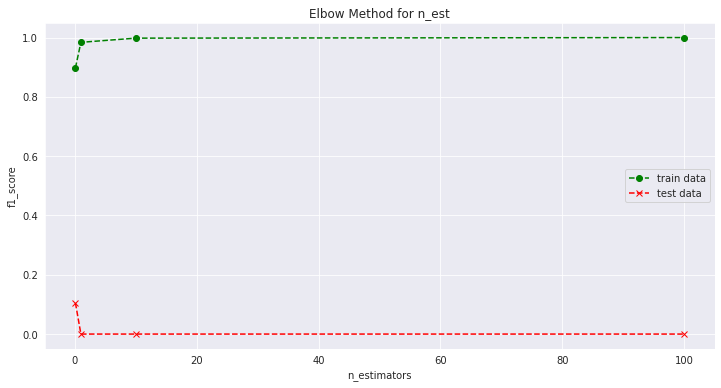

In [ ]:
f1_train = []
f1_test = []
x = [0.1, 1, 10, 100]

for i in x:
    clf = SVC(gamma=i, probability= True)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

Random Forest

1. n_estimators

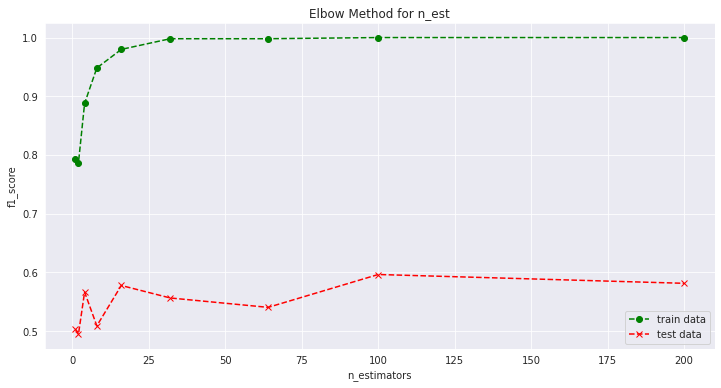

In [ ]:
f1_train = []
f1_test = []
x = [1, 2, 4, 8, 16, 32, 64, 100, 200]

for i in x:
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

2. max_depth

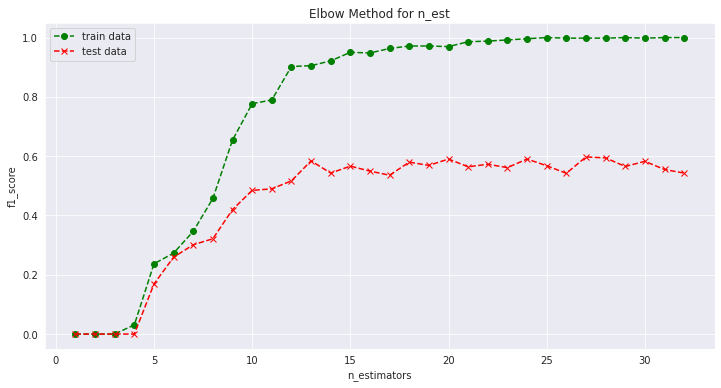

In [ ]:
f1_train = []
f1_test = []
x = np.linspace(1, 32, 32, endpoint=True)

for i in x:
    clf = RandomForestClassifier(n_estimators=64, max_depth=i)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

3. min_samples_split

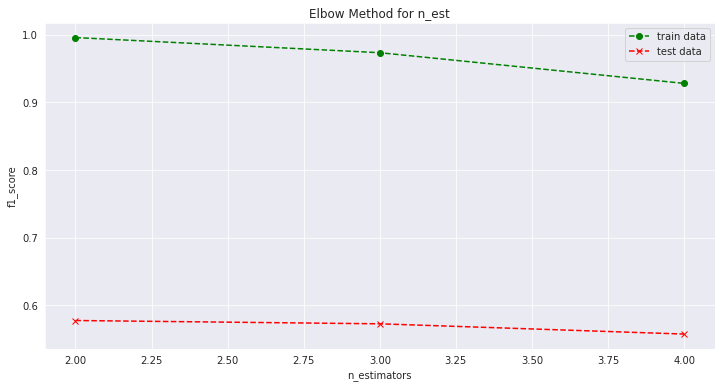

In [ ]:
f1_train = []
f1_test = []
x = range(2,5,1)

for i in x:
    clf = RandomForestClassifier(n_estimators=64, max_depth=25, min_samples_split=i )
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

4. min_samples_leaf

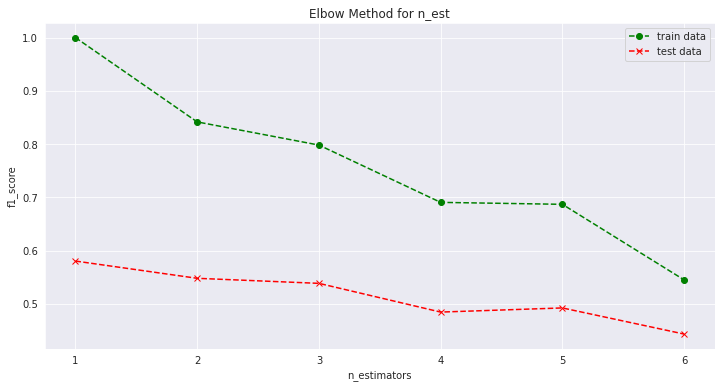

In [ ]:
f1_train = []
f1_test = []
x = range(1,7,1)

for i in x:
    clf = RandomForestClassifier(n_estimators=64, max_depth=25, min_samples_split=2, min_samples_leaf=i )
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

KNN

1. n_neighbors

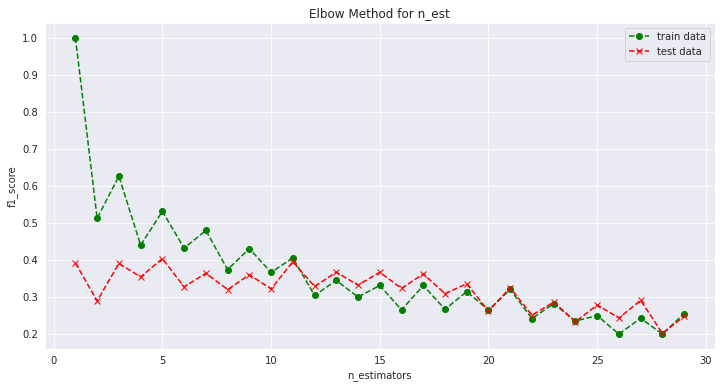

In [ ]:
f1_train = []
f1_test = []
x = range(1,30)

for i in x:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

We are not going to choose 1, since this means that it will label itself with itself which makes no sense. We are going to choose 3.

2. p

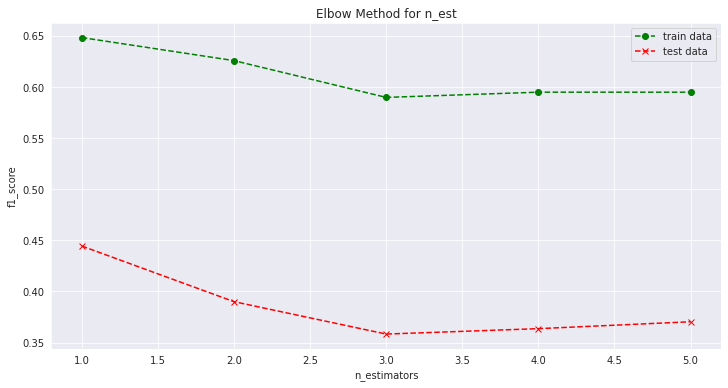

In [ ]:
f1_train = []
f1_test = []
x = [1, 2, 3, 4, 5]

for i in x:
    clf = KNeighborsClassifier(n_neighbors=3, p=i)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

XGBoost

1. max_depth



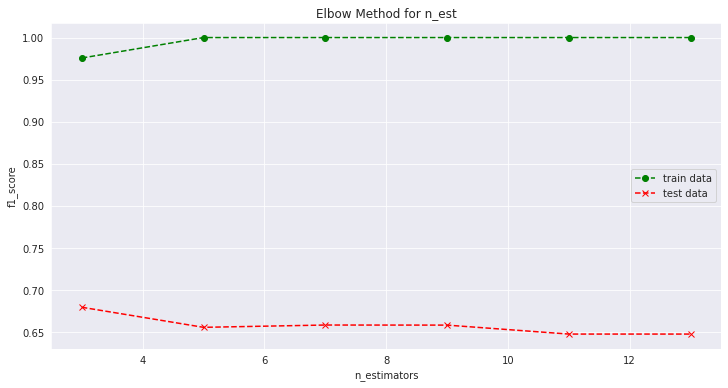

In [ ]:
f1_train = []
f1_test = []
x = range(3,15,2)

for i in x:
    clf = XGBClassifier(learning_rate=0.1,  
                      colsample_bytree = 0.8,
                      subsample = 0.8, 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=i, 
                      min_child_weight = 1,
                      gamma=0)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

2. min_child_weight

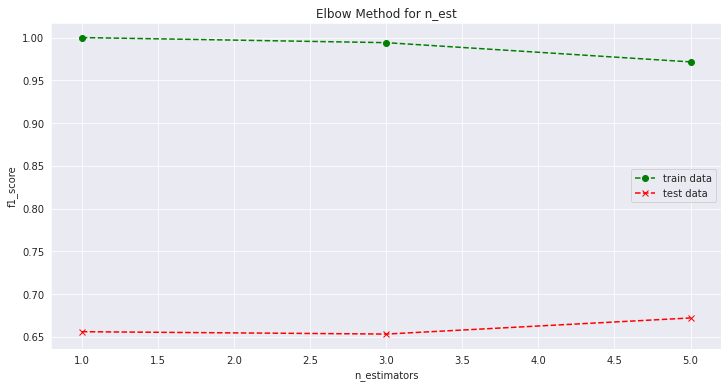

In [ ]:
f1_train = []
f1_test = []
x = range(1,6,2)

for i in x:
    clf = XGBClassifier(learning_rate=0.1,  
                      colsample_bytree = 0.8,
                      subsample = 0.8, 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth= 5, 
                      min_child_weight = i,
                      gamma=0)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

3. gamma

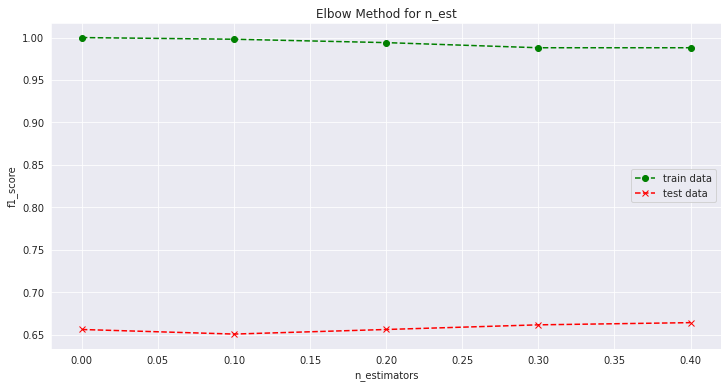

In [ ]:
f1_train = []
f1_test = []
x = [i/10.0 for i in range(0,5)]

for i in x:
    clf = XGBClassifier(learning_rate=0.1,  
                      colsample_bytree = 0.8,
                      subsample = 0.8, 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      min_child_weight = 1,
                      gamma=i)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

4. subsameple

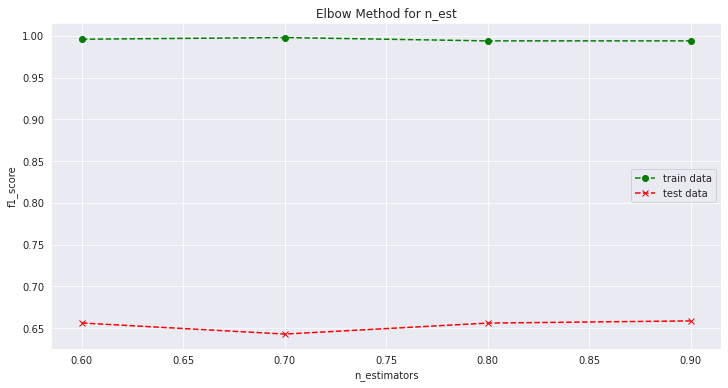

In [ ]:
f1_train = []
f1_test = []
x = [i/10.0 for i in range(6,10)]

for i in x:
    clf = XGBClassifier(learning_rate=0.1,  
                      colsample_bytree = 0.8,
                      subsample = i, 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      min_child_weight = 1,
                      gamma=0.2)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

5. colsample_bytree

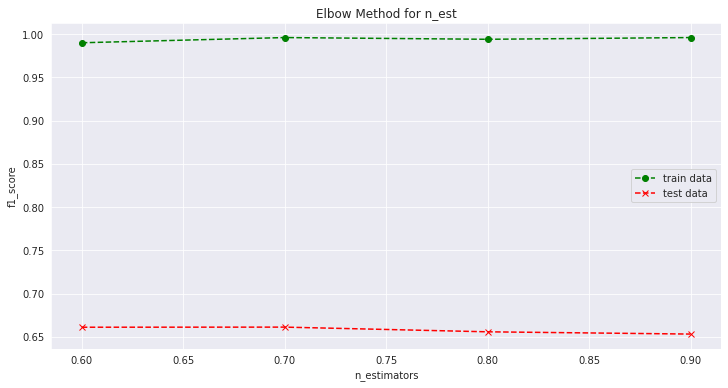

In [ ]:
f1_train = []
f1_test = []
x = [i/10.0 for i in range(6,10)]

for i in x:
    clf = XGBClassifier(learning_rate=0.1,  
                      colsample_bytree = i,
                      subsample =0.8 , 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      min_child_weight = 1,
                      gamma=0.2)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

6. reg_alpha

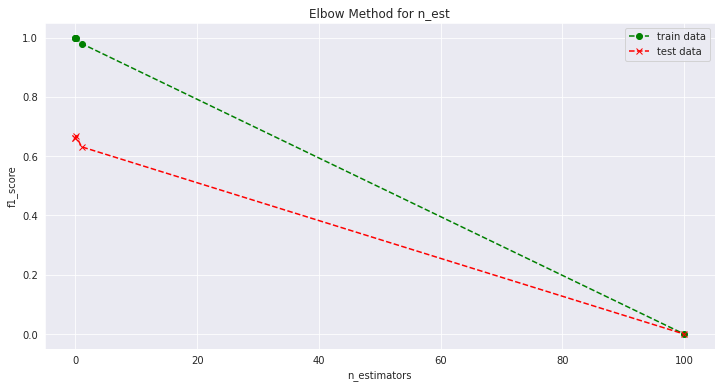

In [ ]:
f1_train = []
f1_test = []
x = [1e-5, 1e-2, 0.1, 1, 100]

for i in x:
    clf = XGBClassifier(learning_rate=0.1,  
                      colsample_bytree = 0.8,
                      subsample = 0.8, 
                      n_estimators=1000, 
                      reg_alpha = i,
                      max_depth=5, 
                      min_child_weight = 1,
                      gamma=0.2)
    clf.fit(X_train, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train)))
    f1_test.append(f1_score(y_test, clf.predict(X_test)))

sns.set_style("darkgrid")

plt.figure(figsize = (12,6))
plt.plot(x,f1_train, color='green', marker='o', linestyle='dashed', label = 'train data')
plt.plot(x,f1_test, color='red', marker='x', linestyle='dashed', label = 'test data')
plt.xlabel("n_estimators")
plt.ylabel("f1_score")
plt.title("Elbow Method for n_est")
plt.legend()

## 2. Models for prediction

In [ ]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision_macro': make_scorer(precision_score), 
           'recall_macro' : make_scorer(recall_score), 
           'f1_weighted' : make_scorer(f1_score), 
           'roc_auc' : make_scorer(roc_auc_score)}
def crossvalidate_model(model, X, y, scoring = scoring, cv = 20):
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=20)
    sorted(scores.keys())
    metrics = ["accuracy", "precision", "recall", "F1", "roc"]
    values = [scores['test_accuracy'].mean(), scores['test_precision_macro'].mean(), scores['test_recall_macro'].mean(), scores['test_f1_weighted'].mean(),scores['test_roc_auc'].mean()]    
    return pd.DataFrame(data={'metric': metrics, 'value': values})

In [ ]:
def test_model(predictions, actual):
    accuracy = accuracy_score(actual, predictions)
    precision = precision_score(actual, predictions)
    recall = recall_score(actual, predictions)
    f1 = f1_score(actual, predictions)
    metrics = ["accuracy", "precision", "recall", "F1"]
    values = [accuracy, precision, recall, f1]    
    return pd.DataFrame(data={'metric': metrics, 'value': values})

In [ ]:
models = {}
models['Logistic Regression'] = LogisticRegression()
models['Decision Tree'] = DecisionTreeClassifier()
models['Support Vector Machine'] = SVC(gamma =10, probability = True)
models['Linear Support Vector Machine'] = LinearSVC(penalty = 'l2', loss= 'squared_hinge', dual = True)
models['Linear Discriminant Analysis'] = LinearDiscriminantAnalysis()
models['Quadratic Discriminant Analysis'] = QuadraticDiscriminantAnalysis()
models['Random Forest'] = RandomForestClassifier(n_estimators=64, max_depth=25, min_samples_split=2, min_samples_leaf=1)
models['K-Nearest Neighbors'] = KNeighborsClassifier(n_neighbors=3, p=1)
models['Gaussian Naive Bayes'] = GaussianNB()
models['XGBoost'] = XGBClassifier(learning_rate=0.1, colsample_bytree = 0.8, subsample = 0.8, n_estimators=1000, reg_alpha = 1e-2, max_depth=5, min_child_weight = 1,gamma=0.2)

In [ ]:
cross_validation_results =  pd.DataFrame({'Metric' : ['Accuracy', 'Precision', 'Recall', 'F1_score']})
test_results = pd.DataFrame({'Metric' : ['Accuracy', 'Precision', 'Recall', 'F1_score']})
for key in models.keys():
    model = models[key]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    cross_validation_results[key] = crossvalidate_model(model, X_train, y_train).value
    test_results[key] = test_model(predictions, y_test).value


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
cross_validation_results

,Metric,Logistic Regression,Decision Tree,Support Vector Machine,Linear Support Vector Machine,Linear Discriminant Analysis,Quadratic Discriminant Analysis,Random Forest,K-Nearest Neighbors,Gaussian Naive Bayes,XGBoost
0,Accuracy,0.940486,0.934290,0.928655,0.927544,0.939337,0.134232,0.944153,0.925833,0.270145,0.950359
1,Precision,0.661672,0.552627,0.000000,0.539825,0.577148,0.075668,0.724461,0.479233,0.084591,0.707110
2,Recall,0.420513,0.552885,0.000000,0.386218,0.713782,0.991987,0.368590,0.323718,0.937179,0.536218
3,F1_score,0.493053,0.543659,0.000000,0.387838,0.630460,0.140593,0.469985,0.382065,0.155114,0.603015


In [ ]:
test_results

,Metric,Logistic Regression,Decision Tree,Support Vector Machine,Linear Support Vector Machine,Linear Discriminant Analysis,Quadratic Discriminant Analysis,Random Forest,K-Nearest Neighbors,Gaussian Naive Bayes,XGBoost
0,Accuracy,0.940919,0.932713,0.923961,0.915755,0.937637,0.135667,0.946937,0.923414,0.270788,0.954048
1,Precision,0.653465,0.555556,0.000000,0.464455,0.566138,0.080861,0.723404,0.495575,0.090535,0.752294
2,Recall,0.474820,0.575540,0.000000,0.705036,0.769784,1.000000,0.489209,0.402878,0.949640,0.589928
3,F1_score,0.550000,0.565371,0.000000,0.560000,0.652439,0.149623,0.583691,0.444444,0.165310,0.661290


The results in the table above show that the model with the highest accuracy is 95%. However, with recall and precision both at 0 in this case, it is clear that the model is simply predicting a default for all classes. Moreover, in the case of credit default, with an uneven class distribution and very different consequences for false positives and false negatives, we believe that precision and recall are the key metrics to look at. Several models have good recall values but sacrifice precision to achieve this. In this case we don't know exactly what balance to strike between precision and recall, indeed it depends on the number of good loans the bank is prepared to miss out on to avoid taking on a bad loan. However, it is likely that the cost of a loanee defaulting is much greater than the interest gained on most loans, so it likely prioritize recall over precision.

### Selecting variables
Before taking a closer look at the balance between precision and recall, we note that the dropoof in performance between the training and the testing is quite steep. This is likely due to overfitting. To mitigate this, we attempt to remove some of the variables with little correlation to `y` given by the correlation table.

In [ ]:
df_less_variables = data.drop(columns = ['Marital_Status', 'Prod_Sub_Category', 'Type_Of_Residence'])
df_less_variables = pd.get_dummies(df_less_variables)

models2 = {}
models2['Logistic Regression'] = LogisticRegression()
models2['Decision Tree'] = DecisionTreeClassifier()
models2['Support Vector Machine'] = SVC(gamma =10, probability = True)
models2['Linear Support Vector Machine'] = LinearSVC(penalty = 'l2', loss= 'squared_hinge', dual = True)
models2['Linear Discriminant Analysis'] = LinearDiscriminantAnalysis()
models2['Quadratic Discriminant Analysis'] = QuadraticDiscriminantAnalysis()
models2['Random Forest'] = RandomForestClassifier(n_estimators=64, max_depth=25, min_samples_split=2, min_samples_leaf=1)
models2['K-Nearest Neighbors'] = KNeighborsClassifier(n_neighbors=3, p=1)
models2['Gaussian Naive Bayes'] = GaussianNB()
models2['XGBoost'] = XGBClassifier(learning_rate=0.1, colsample_bytree = 0.8, subsample = 0.8, n_estimators=1000, reg_alpha = 1e-2, max_depth=5, min_child_weight = 1,gamma=0.2)


df_train = df_less_variables.drop(columns='Y')
y = df_less_variables.Y
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.3)
cross_validation_results =  pd.DataFrame({'Metric' : ['Accuracy', 'Precision', 'Recall', 'F1_score']})
test_results = pd.DataFrame({'Metric' : ['Accuracy', 'Precision', 'Recall', 'F1_score']})
for key in models2.keys():
    model = models2[key]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    cross_validation_results[key] = crossvalidate_model(model, X_train, y_train).value
    test_results[key] = test_model(predictions, y_test).value

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
cross_validation_results

,Metric,Logistic Regression,Decision Tree,Support Vector Machine,Linear Support Vector Machine,Linear Discriminant Analysis,Quadratic Discriminant Analysis,Random Forest,K-Nearest Neighbors,Gaussian Naive Bayes,XGBoost
0,Accuracy,0.942304,0.927941,0.929541,0.914925,0.939913,0.924488,0.948683,0.926886,0.262964,0.953472
1,Precision,0.661335,0.495804,0.000000,0.498655,0.566544,0.085000,0.732044,0.492671,0.083151,0.720934
2,Recall,0.402747,0.508791,0.000000,0.399451,0.732418,0.010714,0.456868,0.401648,0.943681,0.567308
3,F1_score,0.491981,0.495615,0.000000,0.401732,0.634692,0.018180,0.553056,0.434080,0.152809,0.629907


In [ ]:
test_results

,Metric,Logistic Regression,Decision Tree,Support Vector Machine,Linear Support Vector Machine,Linear Discriminant Analysis,Quadratic Discriminant Analysis,Random Forest,K-Nearest Neighbors,Gaussian Naive Bayes,XGBoost
0,Accuracy,0.940484,0.928704,0.921265,0.910105,0.938004,0.921265,0.942963,0.924365,0.267824,0.953503
1,Precision,0.691358,0.550847,0.000000,0.447674,0.589404,0.000000,0.716049,0.529412,0.093991,0.809524
2,Recall,0.440945,0.511811,0.000000,0.606299,0.700787,0.000000,0.456693,0.354331,0.960630,0.535433
3,F1_score,0.538462,0.530612,0.000000,0.515050,0.640288,0.000000,0.557692,0.424528,0.171228,0.644550


Here, we can see some improvements. The best one at the moment is Linear Discriminant Analysis.

## Controlling precision and recall

For some models, we can manually select a preferably balance after training by modifying the intercept. This is the case of the Logistic regression for example. We can sacrifice some accuracy to improve the recall and precision. Below we plot the recall precision combinations we can get for the logistic regression and the Linear Discriminant Analysis.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

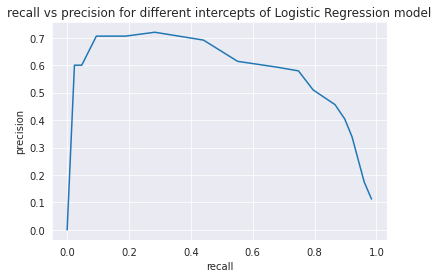

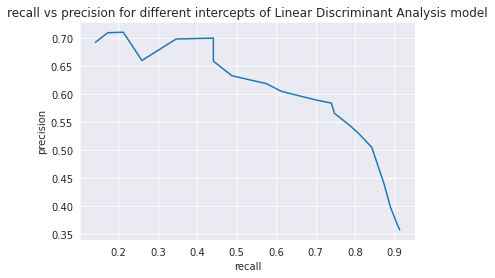

In [ ]:

for key in ['Logistic Regression','Linear Discriminant Analysis']:
    model = models2[key]
    original_value = model.intercept_[0]
    precisions = []
    recall = []
    for k in range(-10,10):
        model.intercept_[0] = original_value + k/2
        predictions = model.predict(X_test)
        res = test_model(predictions, y_test).value
        precisions.append(res[1])
        recall.append(res[2])
    plt.plot(recall, precisions)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('recall vs precision for different intercepts of {} model'.format(key))
    plt.show()
    model.intercept_[0] = original_value

## Under-sampling the data
One way to rebalance the data set is under-sampling, that is removing a number of the cases without default. This keeps real data but has the downside of reducing the dataset size.

In [ ]:
df_tmp = pd.concat([y_train, X_train], axis= 1)

df_pos = df_tmp[df_tmp.Y == 1]
df_neg = df_tmp[df_tmp.Y == 0]

df_neg = df_neg.sample(n=df_pos.shape[0]*2)

In [ ]:
df2 = pd.concat([df_pos, df_neg])

y_train = df2.Y
X_train = df2.drop(columns='Y')

In [ ]:
cross_validation_results =  pd.DataFrame({'Metric' : ['Accuracy', 'Precision', 'Recall', 'F1_score']})
train_results = pd.DataFrame({'Metric' : ['Accuracy', 'Precision', 'Recall', 'F1_score']})
test_results = pd.DataFrame({'Metric' : ['Accuracy', 'Precision', 'Recall', 'F1_score']})
for key in models.keys():
    model = models[key]
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    cross_validation_results[key] = crossvalidate_model(model, X_train, y_train).value
    train_results[key] = test_model(predictions_train, y_train).value
    test_results[key] = test_model(predictions_test, y_test).value


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
cross_validation_results

,Metric,Logistic Regression,Decision Tree,Support Vector Machine,Linear Support Vector Machine,Linear Discriminant Analysis,Quadratic Discriminant Analysis,Random Forest,K-Nearest Neighbors,Gaussian Naive Bayes,XGBoost
0,Accuracy,0.890481,0.831282,0.666667,0.844712,0.889199,0.666667,0.891699,0.851474,0.441635,0.890481
1,Precision,0.858196,0.749296,0.000000,0.793508,0.854755,0.216667,0.858124,0.791886,0.370118,0.851129
2,Recall,0.810165,0.754121,0.000000,0.803571,0.810165,0.026923,0.818132,0.765659,0.954945,0.826099
3,F1_score,0.829602,0.746529,0.000000,0.784412,0.827985,0.046110,0.833625,0.772540,0.532965,0.833822


In [ ]:
test_results

,Metric,Logistic Regression,Decision Tree,Support Vector Machine,Linear Support Vector Machine,Linear Discriminant Analysis,Quadratic Discriminant Analysis,Random Forest,K-Nearest Neighbors,Gaussian Naive Bayes,XGBoost
0,Accuracy,0.922505,0.859268,0.920645,0.921265,0.930564,0.921265,0.920025,0.890267,0.230626,0.923125
1,Precision,0.504902,0.326389,0.000000,0.500000,0.539267,0.000000,0.495238,0.394958,0.091043,0.507389
2,Recall,0.811024,0.740157,0.000000,0.070866,0.811024,0.000000,0.818898,0.740157,0.976378,0.811024
3,F1_score,0.622356,0.453012,0.000000,0.124138,0.647799,0.000000,0.617211,0.515068,0.166555,0.624242


## Over-sampling
Oversampling involves synthesising extra defaults to create a more balanced dataset.

In [ ]:
#Save categorical and numerical variable
categorical_features = df_neg.select_dtypes(include = ["object"]).columns
numerical_features = df_neg.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("Y")

In [ ]:
df_neg = df_tmp[df_tmp.Y == 0]
proportion = int(df_neg.shape[0]/df_pos.shape[0])

df_pos_noise = pd.DataFrame()
mu, sigma = 0, 0.1

for i in range(int(proportion/2)):
    noise = pd.DataFrame(0, index=df_pos.index, columns=df_pos.columns)
    noise[numerical_features] = noise[numerical_features] + np.random.normal(mu, sigma, df_pos[numerical_features].shape)
    
    noise = df_pos + noise
    df_pos_noise = pd.concat([df_pos_noise,noise])

    

In [ ]:
df3 = pd.concat([df_neg,df_pos_noise])

y_train = df3.Y
X_train = df3.drop(columns='Y')

In [ ]:
cross_validation_results =  pd.DataFrame({'Metric' : ['Accuracy', 'Precision', 'Recall', 'F1_score']})
train_results = pd.DataFrame({'Metric' : ['Accuracy', 'Precision', 'Recall', 'F1_score']})
test_results = pd.DataFrame({'Metric' : ['Accuracy', 'Precision', 'Recall', 'F1_score']})
for key in models.keys():
    model = models[key]
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    cross_validation_results[key] = crossvalidate_model(model, X_train, y_train).value
    train_results[key] = test_model(predictions_train, y_train).value
    test_results[key] = test_model(predictions_test, y_test).value
final_res = test_results['Linear Discriminant Analysis']

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
cross_validation_results

,Metric,Logistic Regression,Decision Tree,Support Vector Machine,Linear Support Vector Machine,Linear Discriminant Analysis,Quadratic Discriminant Analysis,Random Forest,K-Nearest Neighbors,Gaussian Naive Bayes,XGBoost
0,Accuracy,0.896782,0.999214,0.687378,0.842292,0.896785,0.995478,1.0,0.959883,0.903466,0.999607
1,Precision,0.853542,1.000000,0.000000,0.785587,0.844267,0.985892,1.0,0.895586,0.790836,1.000000
2,Recall,0.811337,0.997492,0.000000,0.769723,0.824525,1.000000,1.0,0.989312,0.941543,0.998750
3,F1_score,0.831172,0.998738,0.000000,0.753040,0.833468,0.992853,1.0,0.939589,0.859293,0.999371


In [ ]:
test_results

,Metric,Logistic Regression,Decision Tree,Support Vector Machine,Linear Support Vector Machine,Linear Discriminant Analysis,Quadratic Discriminant Analysis,Random Forest,K-Nearest Neighbors,Gaussian Naive Bayes,XGBoost
0,Accuracy,0.933664,0.921265,0.921265,0.796652,0.929324,0.916925,0.921265,0.911965,0.875387,0.921265
1,Precision,0.554348,0.000000,0.000000,0.260143,0.533679,0.111111,0.000000,0.445255,0.349593,0.000000
2,Recall,0.803150,0.000000,0.000000,0.858268,0.811024,0.007874,0.000000,0.480315,0.677165,0.000000
3,F1_score,0.655949,0.000000,0.000000,0.399267,0.643750,0.014706,0.000000,0.462121,0.461126,0.000000


Hence the model we decided to retain as our final model is the Linear Discriminant Analysis model as it had the highest F1 score (on average for three cases : given data, oversampled and undersample data). This means it balances precision and recall (recall being in our view the most important metric) while keeping a high accuracy. Its results on the test set can be found below. 

In [ ]:
final_res

0    0.929324
1    0.533679
2    0.811024
3    0.643750
Name: Linear Discriminant Analysis, dtype: float64